In [1]:
import networkx as nx
import matplotlib.pyplot as plt

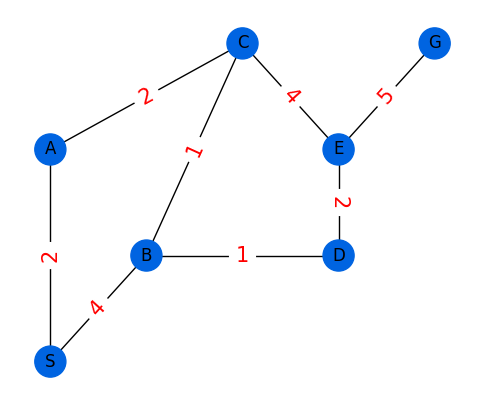

In [3]:
DEFAULT_COLOR = "#0064e1"

def graph_factory():

    node_positions = {
        "S": (0, 0),
        "A": (0, 2),
        "B": (1, 1),
        "C": (2, 3),
        "D": (3, 1),
        "E": (3, 2),
        "G": (4, 3),
    }

    node_colors = {node: DEFAULT_COLOR for node in node_positions.keys()}

    node_attrs = {"positions": node_positions, "colors": node_colors}

    G = nx.Graph()

    G.add_edge("S", "A", weight=2)
    G.add_edge("S", "B", weight=4)
    G.add_edge("A", "C", weight=2)
    G.add_edge("B", "C", weight=1)
    G.add_edge("C", "E", weight=4)
    G.add_edge("B", "D", weight=1)
    G.add_edge("D", "E", weight=2)
    G.add_edge("E", "G", weight=5)

    return G, node_attrs


G, node_attrs = graph_factory()


def draw_graph(ax, G, node_attrs, edge_labels=False):
    nx.draw(G,
            ax=ax,
            pos=node_attrs["positions"],
            with_labels=True,
            node_size=500,
            nodelist=list(node_attrs["colors"].keys()),
            node_color=list(node_attrs["colors"].values()),
            )
    
    if edge_labels:
        nx.draw_networkx_edge_labels(
            G,
            ax=ax,
            pos=node_attrs["positions"],
            edge_labels={edge: G.edges[edge]["weight"] for edge in G.edges},
            font_size=15,
            font_color="red",
            )


fig, ax = plt.subplots(figsize=(6, 5))
draw_graph(ax, G, node_attrs, edge_labels=True)
plt.show()

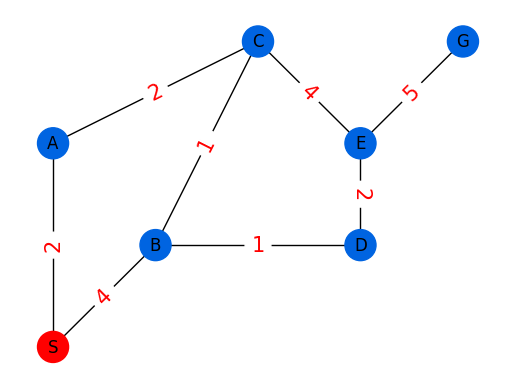

In [4]:
node_attrs["colors"]["S"] = "red"
fig, ax = plt.subplots()
draw_graph(ax, G, node_attrs, edge_labels=True)
plt.show()

## Animate the graph

In [10]:
import matplotlib.animation as animation
import time
%matplotlib widget

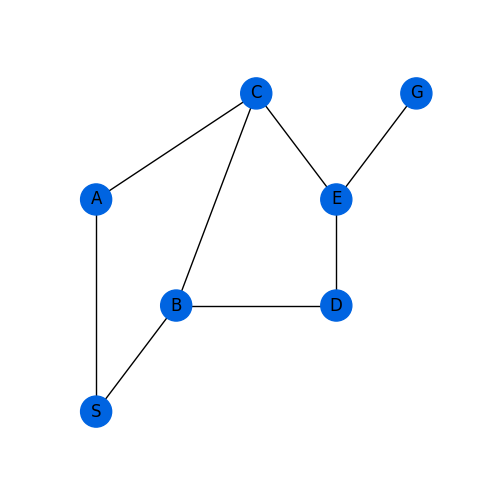

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))

G, node_attrs = graph_factory()

draw_graph(ax, G, node_attrs)

def update(frame):
    global G, node_attrs
    ax.clear()
    nodes = list(node_attrs["colors"].keys())
    node_attrs["colors"][nodes[frame]] = "red"
    draw_graph(ax, G, node_attrs)

ani = animation.FuncAnimation(fig, func=update, interval=1000, frames=7)
plt.show()

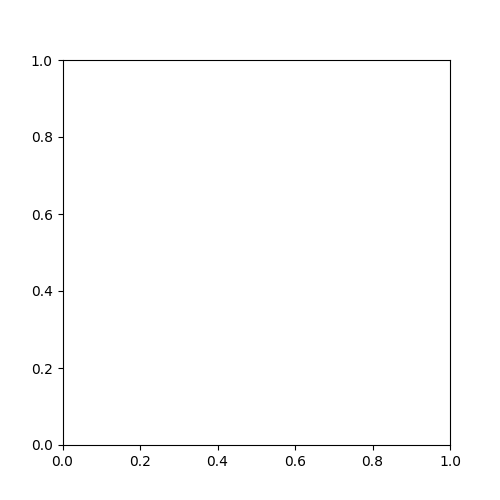

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))

G, node_attrs = graph_factory()

# draw_graph(ax, G, node_attrs)

def update(frame):
    ax.clear()
    nodes = list(node_attrs["colors"].keys())
    node_attrs["colors"][nodes[frame]] = "red"
    # nx.draw_networkx_edges(G,
    #         ax=ax,
    #         pos=node_attrs["positions"],
    #         nodelist=list(node_attrs["colors"].keys()),
    #         node_color=list(node_attrs["colors"].values()),
    #         )
    nx.draw_networkx_nodes(G, pos=node_attrs["positions"], nodelist=nodes, node_color=node_attrs["colors"], ax=ax)

ani = animation.FuncAnimation(fig, func=update, interval=1000, frames=7)
plt.show()
